In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
# used for data visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#used for prediction
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from sklearn.metrics import confusion_matrix
cwd = os.getcwd()

In [2]:
# Read data
path = cwd + "/data/SMSSpamCollection"

with open(path) as file:
    data = file.readlines()

data = list(map(lambda line: line.lower().strip().split("\t"),data))
data_df = pd.DataFrame(data,columns=["Tag","Message"])
spam_data_df = data_df[data_df.Tag == "spam"]
ham_data_df = data_df[data_df.Tag == "ham"]
data_df.head()


,Tag,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


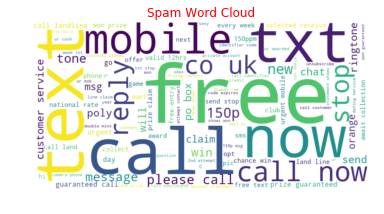

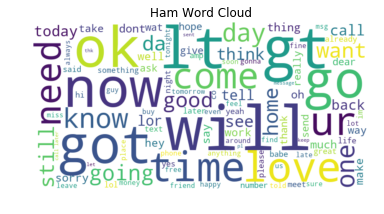

In [3]:
#Plot the Word Cloud for each category
stopwords = set(STOPWORDS)
spam_wc = WordCloud(width=800, 
                    height = 400,
                    stopwords=stopwords,
                    max_words=100, 
                    background_color="white").generate(" ".join(spam_data_df["Message"].tolist()))

ham_wc = WordCloud(width=800, 
                   height = 400,
                   stopwords=stopwords,
                   max_words=100, 
                   background_color="white").generate(" ".join(ham_data_df["Message"].tolist()))

plt.imshow(spam_wc,interpolation='bilinear')
plt.axis("off")
plt.getp(plt.title("Spam Word Cloud"),'text')
plt.setp(plt.title("Spam Word Cloud"),color = 'r')
plt.show()
spam_wc.to_file(cwd+"/img/spam_word_cloud.png")
plt.imshow(ham_wc,interpolation='bilinear')
plt.axis("off")
plt.getp(plt.title("Ham Word Cloud"),'text')
plt.show()
ham_wc.to_file(cwd+"/img/ham_word_cloud.png")

In [4]:
#split data
X_train_data,X_test_data, Y_train_data, Y_test_data =  train_test_split(data_df["Message"], data_df["Tag"], test_size = 0.1)

In [5]:
#convert data
v=DictVectorizer(sparse=False)
train_dictionary= list(map(lambda line:dict(Counter(line)),(list(map(lambda line:line.strip().split(),X_train_data.tolist())))))
train_bag_of_words = v.fit_transform(train_dictionary)

test_dictionary= list(map(lambda line:dict(Counter(line)),(list(map(lambda line:line.strip().split(),X_test_data.tolist())))))
test_bag_of_words = v.transform(test_dictionary)

categories = {"spam":1, "ham":0}
Y_train_data.replace(categories,inplace = True)
Y_test_data.replace(categories,inplace = True)

In [6]:
#Naive bayes
NB_clf = GaussianNB()
NB_clf.fit(train_bag_of_words,Y_train_data.tolist())
Y_NB_pred = NB_clf.predict(test_bag_of_words)
NB_clf.score(test_bag_of_words, Y_test_data)
#print(Y_NB_pred,Y_test_data.tolist())
precision_recall_fscore_support(Y_test_data, Y_NB_pred,labels=[0, 1])

(array([0.99555556, 0.69444444]),
 array([0.93139293, 0.97402597]),
 array([0.96240602, 0.81081081]),
 array([481,  77]))

In [7]:
tn, fp, fn, tp = confusion_matrix(Y_test_data, Y_NB_pred,labels=[0, 1]).ravel()
(tn, fp, fn, tp)

(448, 33, 2, 75)

In [8]:
#SVM
svm_clf = svm.SVC(C=500,gamma="auto")
svm_clf.fit(train_bag_of_words,Y_train_data.tolist())
Y_svm_pred = svm_clf.predict(test_bag_of_words)
precision_recall_fscore_support(Y_test_data, Y_svm_pred,labels=[0, 1])
svm_clf.score(test_bag_of_words,Y_test_data)

0.982078853046595

In [9]:
precision_recall_fscore_support(Y_test_data, Y_svm_pred,labels=[0, 1])

(array([0.98556701, 0.95890411]),
 array([0.99376299, 0.90909091]),
 array([0.98964803, 0.93333333]),
 array([481,  77]))

In [10]:
c=2
while c<=1000:
    svm_clf = svm.SVC(C=c,gamma="auto")
    svm_clf.fit(train_bag_of_words,Y_train_data.tolist())
    Y_svm_pred = svm_clf.predict(test_bag_of_words)
    matrix = precision_recall_fscore_support(Y_test_data, Y_svm_pred,labels=[0, 1])
    score = svm_clf.score(test_bag_of_words,Y_test_data)
    print(str(c) + "\t" + str(matrix) + "\t" + str(score))
    c *= 2

/home/ato42/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2	(array([0.86200717, 0.        ]), array([1., 0.]), array([0.92589028, 0.        ]), array([481,  77]))	0.8620071684587813


/home/ato42/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4	(array([0.86200717, 0.        ]), array([1., 0.]), array([0.92589028, 0.        ]), array([481,  77]))	0.8620071684587813
8	(array([0.87137681, 1.        ]), array([1.        , 0.07792208]), array([0.93126815, 0.14457831]), array([481,  77]))	0.8727598566308243
16	(array([0.93217054, 1.        ]), array([1.        , 0.54545455]), array([0.96489468, 0.70588235]), array([481,  77]))	0.9372759856630825
32	(array([0.9796334, 1.       ]), array([1.        , 0.87012987]), array([0.98971193, 0.93055556]), array([481,  77]))	0.982078853046595
64	(array([0.98151951, 0.95774648]), array([0.99376299, 0.88311688]), array([0.98760331, 0.91891892]), array([481,  77]))	0.978494623655914
128	(array([0.98350515, 0.94520548]), array([0.99168399, 0.8961039 ]), array([0.98757764, 0.92      ]), array([481,  77]))	0.978494623655914
256	(array([0.98553719, 0.94594595]), array([0.99168399, 0.90909091]), array([0.98860104, 0.92715232]), array([481,  77]))	0.9802867383512545
512	(array([0.98556701, 0.95890411

In [11]:
pip list

Package              Version      
-------------------- -------------
absl-py              0.7.1        
astor                0.7.1        
attrs                18.2.0       
backcall             0.1.0        
bleach               3.1.0        
cycler               0.10.0       
decorator            4.4.0        
defusedxml           0.5.0        
entrypoints          0.3          
enum34               1.1.6        
gast                 0.2.2        
grpcio               1.19.0       
h5py                 2.9.0        
import-ipynb         0.1.3        
ipykernel            5.1.0        
ipython              7.3.0        
ipython-genutils     0.2.0        
ipywidgets           7.4.2        
jedi                 0.13.3       
Jinja2               2.10         
jsonschema           3.0.1        
jupyter              1.0.0        
jupyter-client       5.2.4        
jupyter-console      6.0.0        
jupyter-core         4.4.0        
jupyter-http-over-ws 0.0.6        
Keras-Applications  